## 0. Первичная инициализация

Импорт библиотек, задание переменных, констант.

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

import MetaTrader5 as mt5 # для работы с торговой платформой

import threading # для многопоточности
import pickle # сохранение объектов

from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.metrics import make_scorer #создание метрики
from sklearn import model_selection #методы разделения и валидации

from prophet import Prophet
#from neuralprophet import NeuralProphet

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import optuna # для оптимизации гиперпараметров
import pmdarima as pm # для автоматического подбора гиперпараметров

from statsmodels.tsa.arima.model import ARIMA # для модели ARIMA

import datetime as dt
from datetime import datetime

from tqdm import tqdm  # для отображения прогресса долгих рассчетов
tqdm.pandas()

from IPython.display import clear_output # для очистки вывода
import logging # для логирования
import random # для генерации случайных чисел
import winsound  # пищим динамиком, когда надо
import time

pd.options.mode.chained_assignment = None  # для подавления предупреждений

In [2]:
# зададим переменные
random_state = 42
symbol = "EURUSDrfd"
time_delta = 10 * 60 # 10 минут - время, которое нас интересует в качестве предсказания для пипсовой торговли
pips_delta = 0.00025 # 25 пипсов - минимальное изменение цены, которое нас интересует в качестве предсказания для пипсовой торговли (это мы вычислим позже)

In [3]:
# функция, что-бы попищать динамиком. Полезно, что-бы просигналить, что долгий рассчёт окончен

def beep():
    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 500  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(round(frequency/4), duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(frequency, duration)

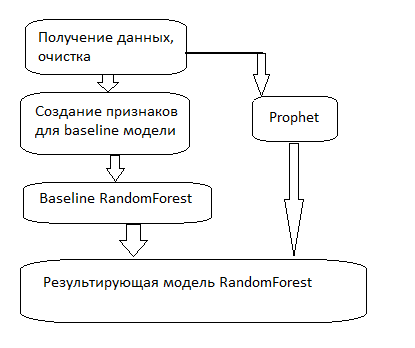

# 7. Production

На этом этапе запускаем Metatrader, получаем данные, обрабатываем их по нашей схеме нашими моделями, получаем предсказание, в зависимости от предсказания - размещаем ордер на покупку<br>
Выставляем для него stop-loss и take-profit. Так-же следим, что-бы ордер висел не дольше 10 минут. После чего - принудительно его закрываем.

#### загружаем все наши модели, необходимые для работы

In [4]:
# загрузим модели
model_bl = pickle.load(open('pkl/model.pkl', 'rb'))
model_ensemble = pickle.load(open('pkl/model_ensemble.pkl', 'rb'))

# загрузим название колонок из файла
with open("pkl/columns.pkl", "rb") as f:
    colmn = pickle.load(f)

In [5]:
# отключаем спам о выполнении каждой операции прогноза Prophet
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [6]:
# Создадим функцию для записи лога работы нашего торгового робота
def print_log(txt):
    log_file = open('logfile.txt', 'a')  # 'a' для режима добавления (append)
    # Ваш код и вывод
    #print("Этот вывод пойдет в стандартный вывод")
    log_file.write(str(txt) + '\n')
    # Закрываем файл
    log_file.close()

In [7]:
# выведем данные о пакете MetaTrader5
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.45


In [8]:
# установим подключение к терминалу MetaTrader 5 на указанный торговый счет
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [9]:
# напишем функцию размещения торгового ордера
def make_order(x=1,symbol=symbol):
    # подготовим структуру запроса для покупки    
    symbol_info = mt5.symbol_info(symbol)
    if symbol_info is None:
        print(symbol, "not found, can not call order_check()")
        print_log(symbol, "not found, can not call order_check()")
        #mt5.shutdown()
        #quit()

    lot = 0.01
    point = mt5.symbol_info(symbol).point
    price_buy = mt5.symbol_info_tick(symbol).ask
    price_sell = mt5.symbol_info_tick(symbol).bid
    stop_level = mt5.symbol_info(symbol).trade_stops_level
    if stop_level == 0:
        stop_level = 10
    deviation = 10
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": mt5.ORDER_TYPE_BUY,
        #"price": price_buy,
        #"sl": price_buy - 6 * stop_level * point,
        #"tp": price_buy + 7 * stop_level * point,
        "sl": price_buy - pips_delta,
        "tp": price_buy + pips_delta,
        "deviation": deviation,
        "magic": 234000,
        "comment": "python script open",
        "type_time": mt5.ORDER_TIME_GTC,
        #"type_filling": mt5.ORDER_FILLING_RETURN,        
    }
    if x==-1:
        request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": mt5.ORDER_TYPE_SELL,
        #"price": price_sell,
        #"sl": price_sell + 6 * stop_level * point,
        #"tp": price_sell - 7 * stop_level * point,
        "sl": price_sell + pips_delta,
        "tp": price_sell - pips_delta,
        "deviation": deviation,
        "magic": 234000,
        "comment": "python script open",
        "type_time": mt5.ORDER_TIME_GTC,
        #"type_filling": mt5.ORDER_FILLING_RETURN,        
    }
    # отправим торговый запрос
    result = mt5.order_send(request)
    # проверим результат выполнения
    #print("1. order_send(): by {} {} lots at {} with deviation={} points".format(symbol,lot,price,deviation));
    print_log("1. order_send(): by {} lots".format(symbol));
    if result.retcode != mt5.TRADE_RETCODE_DONE:
        print("2. order_send failed, retcode={}".format(result.retcode))
        print_log("2. order_send failed, retcode={}".format(result.retcode))
        # запросим результат в виде словаря и выведем поэлементно
        result_dict=result._asdict()
        for field in result_dict.keys():
            print("   {}={}".format(field,result_dict[field]))
            print_log("   {}={}".format(field,result_dict[field]))
            # если это структура торгового запроса, то выведем её тоже поэлементно
            if field=="request":
                traderequest_dict=result_dict[field]._asdict()
                for tradereq_filed in traderequest_dict:
                    print("       traderequest: {}={}".format(tradereq_filed,traderequest_dict[tradereq_filed]))
                    print_log("       traderequest: {}={}".format(tradereq_filed,traderequest_dict[tradereq_filed]))
        #print("shutdown() and quit")
        #mt5.shutdown()
        #quit()

In [10]:
# Функция для подсчета RSI. Тоже возьмем за признак

def calculate_rsi(prices):
    deltas = np.diff(prices)
    positive_deltas = np.where(deltas > 0, deltas, 0)
    negative_deltas = np.where(deltas < 0, -deltas, 0)    
    avg_gain = np.mean(positive_deltas)
    avg_loss = np.mean(negative_deltas)    
    rs = avg_gain / avg_loss if avg_loss != 0 else 0
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [11]:
# создадим функцию проверки таймаута ордера. Который будет закрывать ордер по таймауту
def check_timeout(t=10*60):    
    # получим открытые позиции    
    positions=mt5.positions_get()
    if positions==None:
        pass
        #print("No positions on USDCHF, error code={}".format(mt5.last_error()))
    elif len(positions)>0:
        #print("Total positions =",len(positions))
        # выведем все открытые позиции
        for position in positions:
                        
            time_order = position.time - 3*60*60
            time_now = datetime.timestamp(datetime.now())
                        
            #if position.profit < -0.5 or position.profit > 0.6 :
            if time_now - time_order > t :
                          
                position_id=position.ticket
                symbol = position.symbol
                if position.type == 0:
                    price=mt5.symbol_info_tick(symbol).bid
                    ttt = mt5.ORDER_TYPE_SELL
                else:
                    price=mt5.symbol_info_tick(symbol).ask
                    ttt = mt5.ORDER_TYPE_BUY           
                
                deviation=20
                lot = position.volume
                request={
                    "action": mt5.TRADE_ACTION_DEAL,
                    "symbol": symbol,
                    "volume": lot,
                    "type": ttt,
                    "position": position_id,
                    "price": price,
                    "deviation": deviation,
                    "magic": 234000,
                    "comment": "python script close",
                    "type_time": mt5.ORDER_TIME_GTC,
                    #"type_filling": mt5.ORDER_FILLING_RETURN,
                }
                # отправим торговый запрос
                result=mt5.order_send(request)          
    

Основное тело цикла работы робота. Выполняем, пока не остановим.

In [12]:
pips_delta = 0.00025 # 25 пипсов
t_names = ['bid','ask','time'] # названия колонок для тиковых данных
times_ticks = [5, 60, 5*60, 30*60, 2*60*60] # временные интервалы скользящих окон для тиков
threshold_class1 = 0.52 # выберем порог 0.52 для класса 1, чуть повысим по результатам первых запусков. Ордеров получается много - глаза разбегаются.

while True:

    current_time = dt.datetime.now()    
    time_2_hours_ago = current_time - dt.timedelta(hours=2.01) # возьмем чуть больше 2 часов, чтобы точно поймать 2 часа

    #ticks = mt5.copy_ticks_from(symbol,
    ticks = mt5.copy_ticks_range(symbol,
                                time_2_hours_ago,
                                current_time,
                                # и за последние 2 часа                                
                                #mt5.COPY_TICKS_ALL)
                                mt5.COPY_TICKS_INFO)

    df_X = pd.DataFrame()    
    df_X = pd.DataFrame(columns=colmn)
    # Добавление пустой строки с индексом 1
    df_X.loc[1] = [None] * len(colmn)
    df_X.drop(['bid','ask','time'], axis=1, inplace=True)    
    
    
    # создадим из полученных данных DataFrame и обработаем его так, как обрабатывали наши данные
    ticks_frame = pd.DataFrame(ticks, columns=['time', 'bid', 'ask'])    
    ticks_frame['time'] = pd.to_datetime(ticks_frame['time'], unit='s')    
    ticks_frame = ticks_frame.resample('1S', on='time').agg({'bid':'mean', 'ask':'mean', 'time':'count'})
    ticks_frame = ticks_frame.fillna(method='ffill')    
    
    len_df = len(ticks_frame) # длина датафрейма
    
    for t in t_names:
        for i in times_ticks: 
            df_t = ticks_frame[t].to_numpy() # преобразуем в Numpy. Как показали тесты - Numpy считается значительно быстрее Pandas    

            name_col = t + '_mean_' + str(i) # название колонки
            name_col_std = t + '_std_' + str(i)
            name_col_bol1 = t + '_bol1_' + str(i)
            name_col_bol2 = t + '_bol2_' + str(i)
            name_col_rsi = 'rsi_' + str(i)

            result = 0
            result_std = 0
            result_bol1 = 0
            result_bol2 = 0
            result_rsi = 0
            #print (datetime.now().hour,datetime.now().minute,name_col)
            
            #for j in range(times_ticks[-1]+1, len_df): # не надо цикл! Надо подсчитать для последнего значения!!!!!!!!            
            #x = df[t][j-i:j].copy() # выбрали наше окно
            j=-1
            x = df_t[j-i:j].copy() # выбрали наше окно
            t_x = df_t[j] # выбрали наше значения
            sma = np.mean(x)  # среднее значение
            result = sma - t_x
            result_std = np.std(x) # стандартное отклонение
            result_bol1 = sma + (2 * result_std) # верхняя полоса Боллинджера
            result_bol2 = sma - (2 * result_std) # нижняя полоса Боллинджера
            result_rsi = calculate_rsi(x)            
            
            df_X[name_col] = result
            df_X[name_col_std] = result_std
            df_X[name_col_bol1] = result_bol1
            df_X[name_col_bol2] = result_bol2
            df_X[name_col_rsi] = result_rsi
    
    # Делаем предсказание для baseline модели
        
    pred_bl_class1 = model_bl.predict_proba(df_X)[:, 2]
    pred_bl_class0 = model_bl.predict_proba(df_X)[:, 1]
    pred_bl_minus1 = model_bl.predict_proba(df_X)[:, 0]
    
    # Теперь получим предсказания от Prophet модели
    # Приводим данные к формату для Prophet
    X_prophet_bid = pd.DataFrame(ticks_frame['bid'])
    X_prophet_bid = X_prophet_bid.reset_index()
    X_prophet_bid.rename(columns = {'time':'ds'}, inplace = True)
    X_prophet_bid.rename(columns = {'bid':'y'}, inplace = True)

    X_prophet_ask = pd.DataFrame(ticks_frame['ask'])
    X_prophet_ask = X_prophet_ask.reset_index()
    X_prophet_ask.rename(columns = {'time':'ds'}, inplace = True)
    X_prophet_ask.rename(columns = {'ask':'y'}, inplace = True)

    # создаём пустой датафрейм, куда будем сохранять результаты
    results_df = pd.DataFrame()
    #results_df['signal'] = ticks_frame_target['signal']
    #results_df['signal_predict'] = 999 # чтобы было видно, что это не предсказание
    #results_df['signal_light'] = 999 # чтобы было видно, что это не "облегченный" сигнал
    results_df['ask_yhat'] = 999
    results_df['ask_yhat_lower'] = 999
    results_df['ask_yhat_upper'] = 999
    results_df['bid_yhat'] = 999
    results_df['bid_yhat_lower'] = 999
    results_df['bid_yhat_upper'] = 999


    # Добавление пустой строки с индексом 1
    results_df.loc[1] = [None] * len(results_df.columns)

    model_ask = Prophet()
    model_bid = Prophet()

    model_ask.fit(X_prophet_ask[-7201:-1])
    model_bid.fit(X_prophet_bid[-7201:-1])

    pred_len = 600 # длина предсказания в секундах

    future_df_ask = model_ask.make_future_dataframe(periods=pred_len, freq='S')
    future_df_bid = model_bid.make_future_dataframe(periods=pred_len, freq='S')

    forecast_df_ask = model_ask.predict(future_df_ask)
    forecast_df_bid = model_bid.predict(future_df_bid)

    # вычислим предсказанные параметры
    ask_pred = forecast_df_ask['yhat'].iloc[-1:].values[0]
    bid_pred = forecast_df_bid['yhat'].iloc[-1:].values[0]

    # запишем результаты в датафрейм
    results_df['ask_yhat'] = ask_pred
    results_df['ask_yhat_lower'] = forecast_df_ask['yhat_lower'].iloc[-1:].values[0]
    results_df['ask_yhat_upper'] = forecast_df_ask['yhat_upper'].iloc[-1:].values[0]

    results_df['bid_yhat'] = bid_pred
    results_df['bid_yhat_lower'] = forecast_df_bid['yhat_lower'].iloc[-1:].values[0]
    results_df['bid_yhat_upper'] = forecast_df_bid['yhat_upper'].iloc[-1:].values[0]

    # Получили предсказания от Prophet модели
    # Теперь соберем данные для ансамбля
    X = results_df[['bid_yhat', 'bid_yhat_lower', 'bid_yhat_upper', 'ask_yhat', 'ask_yhat_lower', 'ask_yhat_upper']]

    # Запишем в X pred_bl_class1, pred_bl_class0, pred_bl_minus1
    X['class_m1'] = pred_bl_minus1
    X['class_0'] = pred_bl_class0
    X['class_1'] = pred_bl_class1

    X['bid'] = ticks_frame['bid'].iloc[-1:].values[0]
    X['ask'] = ticks_frame['ask'].iloc[-1:].values[0]
    X['bid_diff'] = X['bid_yhat'] - X['bid']
    X['ask_diff'] = X['ask_yhat'] - X['ask']
    X['bid_diff_lower'] = X['bid_yhat_lower'] - X['bid']
    X['ask_diff_lower'] = X['ask_yhat_lower'] - X['ask']
    X['bid_diff_upper'] = X['bid_yhat_upper'] - X['bid']
    X['ask_diff_upper'] = X['ask_yhat_upper'] - X['ask']

    # удалим ненужные колонки
    X.drop(['bid_yhat', 'ask_yhat', 'bid_yhat_lower', 'ask_yhat_lower', 'bid_yhat_upper', 'ask_yhat_upper','bid','ask'], axis=1, inplace=True)

    # получим предсказание от ансамбля
    
    y_pred_minus1 = model_ensemble.predict_proba(X)[:, 0][0]
    y_pred_zero = model_ensemble.predict_proba(X)[:, 1][0]
    y_pred_class1 = model_ensemble.predict_proba(X)[:, 2][0]

    # если предсказание превышает порог, то делаем сделку
    order_warn=''
    if y_pred_class1 > threshold_class1:
        make_order(1,symbol)
        order_warn=' ORDER BUY !!!'
    
    # Запишем лог для отладки
    if order_warn != '':
        print_log(str(current_time) + ' ' + symbol + ' ' + str(y_pred_minus1) + ' ' + str(y_pred_zero) + ' ' + str(y_pred_class1) + order_warn)  
    else:
        print_log(str(current_time) + ' ' + symbol + ' ' + str(y_pred_minus1) + ' ' + str(y_pred_zero) + ' ' + str(y_pred_class1))
    
    # проверим таймаут ордеров
    check_timeout()
    time.sleep(20)

# Итоговый вывод

Конечно, написать коммерчески успешный робот - не получилось (иначе я-бы эту дипломную работу не сдавал)))) , однако, предсказания работают относительно неплохо, выявляют закономерности, и пытаются сделать предсказания, которые в любом случае значительно выше случайного значения. Торговый робот - работает. Получает данные с торгового терминала, делает предсказание, выставляет торговый ордер с набором параметров (stop-loss/take-profit), следит за таймаутами ордеров.<br>
Для того, что-бы эта модель стала работать выгодной - предстоит еще много работы - изучение ошибок модели, добавление и конструирование других признаков, иных моделей в ансамбль, очень много тестирования и проб. Но это уже всё не в рамках этой дипломной работы.
 
 

Вот скриншот последних выполненных ордеров работы робота из программы MetaTrader. Все они были сделаны этим роботом из данного ноутбука
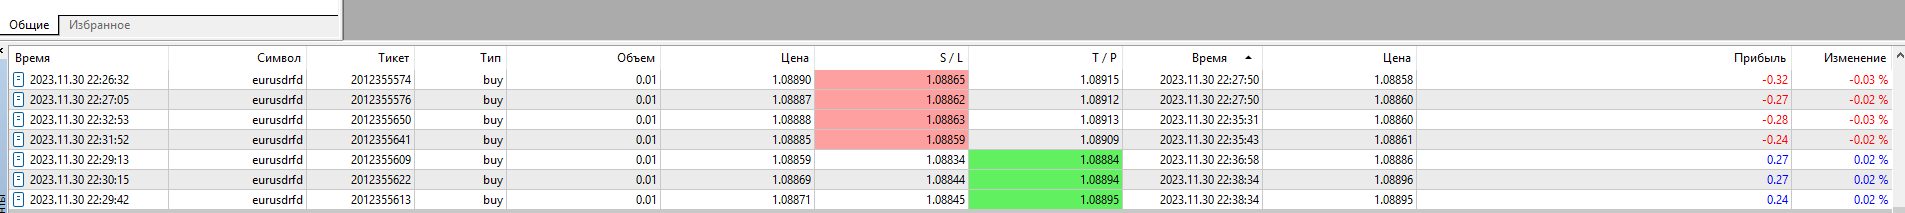
